# **Libaries importing**

In [ ]:
import re
import json
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# pip install yellowbrick
from yellowbrick.text import TSNEVisualizer
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from gensim.utils import simple_preprocess

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Read and preprocess data
movies = pd.read_csv('tmdb_5000_movies.csv')
credits = pd.read_csv('tmdb_5000_credits.csv')

# **Data Analysis and cleaning**

In [ ]:
final_df = pd.concat([credits,movies],axis=1)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_id              1154 non-null   float64
 1   title                 1154 non-null   object 
 2   cast                  1154 non-null   object 
 3   crew                  1154 non-null   object 
 4   budget                4803 non-null   int64  
 5   genres                4803 non-null   object 
 6   homepage              1712 non-null   object 
 7   id                    4803 non-null   int64  
 8   keywords              4803 non-null   object 
 9   original_language     4803 non-null   object 
 10  original_title        4803 non-null   object 
 11  overview              4800 non-null   object 
 12  popularity            4803 non-null   float64
 13  production_companies  4803 non-null   object 
 14  production_countries  4803 non-null   object 
 15  release_date         

In [ ]:
movies_df = final_df[['movie_id','original_title','crew','release_date','genres','keywords','production_companies', 'overview',
                   'production_countries','revenue','budget','runtime','vote_average']]
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_id              1154 non-null   float64
 1   original_title        4803 non-null   object 
 2   crew                  1154 non-null   object 
 3   release_date          4802 non-null   object 
 4   genres                4803 non-null   object 
 5   keywords              4803 non-null   object 
 6   production_companies  4803 non-null   object 
 7   overview              4800 non-null   object 
 8   production_countries  4803 non-null   object 
 9   revenue               4803 non-null   int64  
 10  budget                4803 non-null   int64  
 11  runtime               4801 non-null   float64
 12  vote_average          4803 non-null   float64
dtypes: float64(3), int64(2), object(8)
memory usage: 487.9+ KB


In [ ]:
movies_df['profit'] = movies_df['revenue'] - movies_df['budget']
movies_df.head()

,movie_id,original_title,crew,release_date,genres,keywords,production_companies,overview,production_countries,revenue,budget,runtime,vote_average,profit
0,19995.0,Avatar,"[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",2009-12-10,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""name"": ""Ingenious Film Partners"", ""id"": 289...","In the 22nd century, a paraplegic Marine is di...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2787965087,237000000,162.0,7.2,2550965087
1,285.0,Pirates of the Caribbean: At World's End,"[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",2007-05-19,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","Captain Barbossa, long believed to be dead, ha...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",961000000,300000000,169.0,6.9,661000000
2,206647.0,Spectre,"[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",2015-10-26,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",A cryptic message from Bond’s past sends him o...,"[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",880674609,245000000,148.0,6.3,635674609
3,49026.0,The Dark Knight Rises,"[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",2012-07-16,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",Following the death of District Attorney Harve...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1084939099,250000000,165.0,7.6,834939099
4,49529.0,John Carter,"[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",2012-03-07,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","John Carter is a war-weary, former military ca...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",284139100,260000000,132.0,6.1,24139100


## Top 10 movies with most revenue

In [ ]:
revenue_movies = movies_df.sort_values('revenue',ascending=False)[:10]

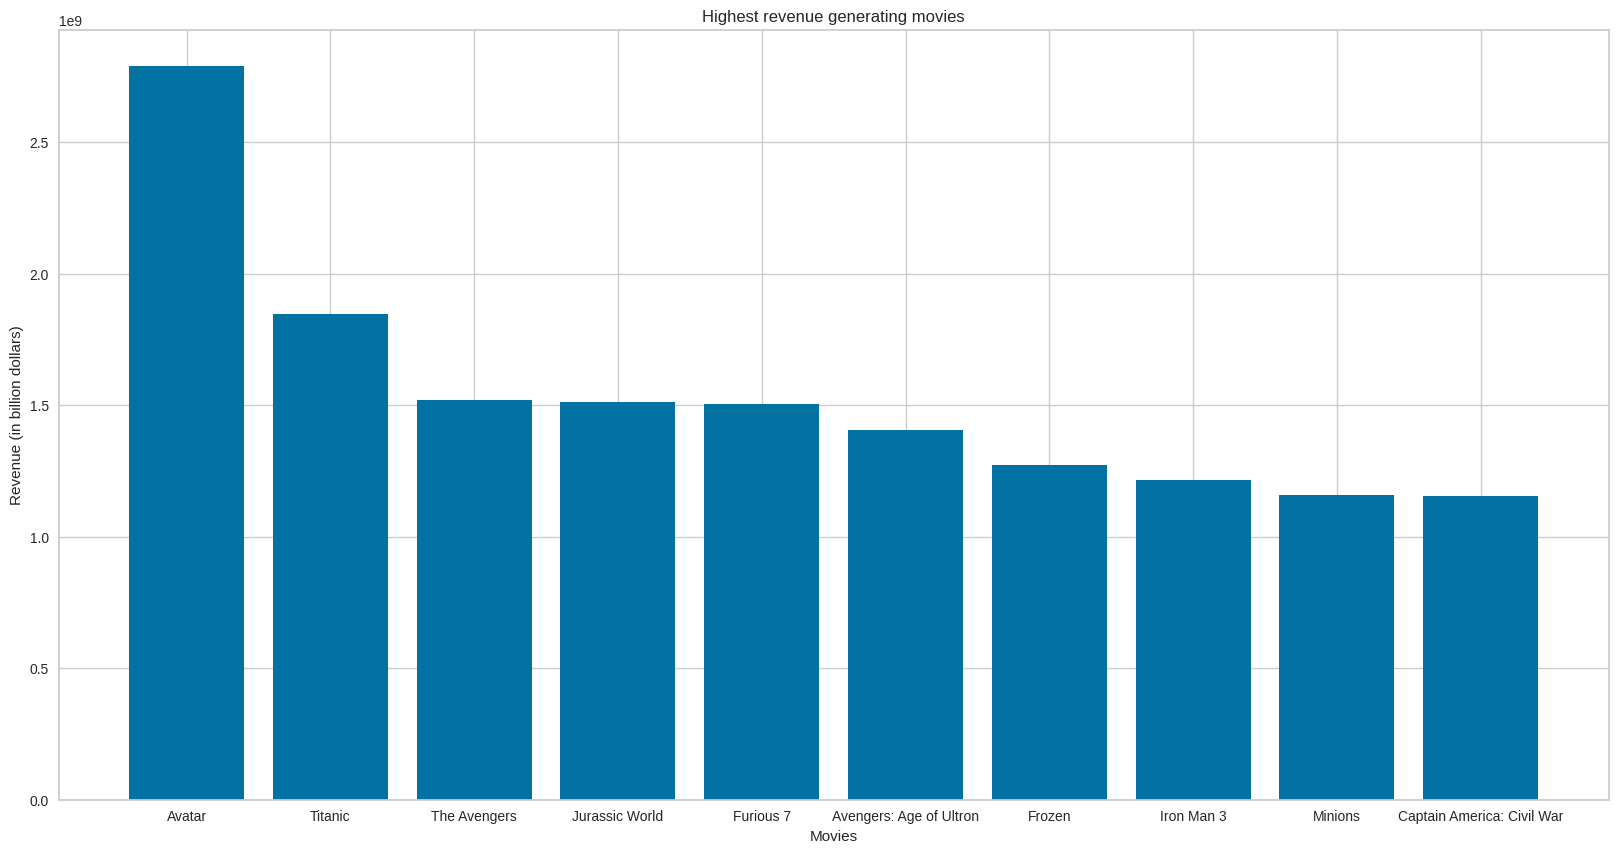

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(revenue_movies['original_title'], revenue_movies['revenue'])
plt.title('Highest revenue generating movies')
plt.xlabel('Movies')
plt.ylabel('Revenue (in billion dollars)')
plt.xticks(rotation=0)
plt.show()

In [ ]:
release_date_null = movies_df['release_date'].isnull()
movies_df.loc[release_date_null,:]

,movie_id,original_title,crew,release_date,genres,keywords,production_companies,overview,production_countries,revenue,budget,runtime,vote_average,profit
4553,NaN,America Is Still the Place,NaN,NaN,[],[],[],1971 post civil rights San Francisco seemed li...,[],0,0,0.0,0.0,0


In [ ]:
movies_df['release_date'] = movies['release_date'].fillna('2014-06-01')
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'],format='%Y-%m-%d')
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   movie_id              1154 non-null   float64       
 1   original_title        4803 non-null   object        
 2   crew                  1154 non-null   object        
 3   release_date          4803 non-null   datetime64[ns]
 4   genres                4803 non-null   object        
 5   keywords              4803 non-null   object        
 6   production_companies  4803 non-null   object        
 7   overview              4800 non-null   object        
 8   production_countries  4803 non-null   object        
 9   revenue               4803 non-null   int64         
 10  budget                4803 non-null   int64         
 11  runtime               4801 non-null   float64       
 12  vote_average          4803 non-null   float64       
 13  profit            

In [ ]:
runtime_date_null = movies_df['runtime'].isnull()
movies_df.loc[runtime_date_null,:]

,movie_id,original_title,crew,release_date,genres,keywords,production_companies,overview,production_countries,revenue,budget,runtime,vote_average,profit
2656,NaN,Chiamatemi Francesco - Il Papa della gente,NaN,2015-12-03,"[{""id"": 18, ""name"": ""Drama""}]","[{""id"": 717, ""name"": ""pope""}, {""id"": 5565, ""na...","[{""name"": ""Taodue Film"", ""id"": 45724}]",NaN,"[{""iso_3166_1"": ""IT"", ""name"": ""Italy""}]",0,15000000,NaN,7.3,-15000000
4140,NaN,"To Be Frank, Sinatra at 100",NaN,2015-12-12,"[{""id"": 99, ""name"": ""Documentary""}]","[{""id"": 6027, ""name"": ""music""}, {""id"": 225822,...","[{""name"": ""Eyeline Entertainment"", ""id"": 60343}]",NaN,"[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",0,2,NaN,0.0,-2


In [ ]:
values1 = {'runtime':98.0}
values2 = {'runtime':81.0}
movies_df.fillna(value=values1,limit = 1,inplace = True)
movies_df.fillna(value=values2,limit = 1,inplace = True)
movies_df.loc[runtime_date_null,:]

,movie_id,original_title,crew,release_date,genres,keywords,production_companies,overview,production_countries,revenue,budget,runtime,vote_average,profit
2656,NaN,Chiamatemi Francesco - Il Papa della gente,NaN,2015-12-03,"[{""id"": 18, ""name"": ""Drama""}]","[{""id"": 717, ""name"": ""pope""}, {""id"": 5565, ""na...","[{""name"": ""Taodue Film"", ""id"": 45724}]",NaN,"[{""iso_3166_1"": ""IT"", ""name"": ""Italy""}]",0,15000000,98.0,7.3,-15000000
4140,NaN,"To Be Frank, Sinatra at 100",NaN,2015-12-12,"[{""id"": 99, ""name"": ""Documentary""}]","[{""id"": 6027, ""name"": ""music""}, {""id"": 225822,...","[{""name"": ""Eyeline Entertainment"", ""id"": 60343}]",NaN,"[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",0,2,81.0,0.0,-2


In [ ]:
import ast
def convert(text):
    arr = []
    count = 0
    for i in ast.literal_eval(text):
         if count<1:
            arr.append(i['name'])
            count+=1
    return arr

movies_df['genres'] = movies_df['genres'].apply(convert)

In [ ]:
movies_df['genres'] = movies_df['genres'].apply(lambda x: " ".join(x))

In [ ]:
movies_df.sample(3)

,movie_id,original_title,crew,release_date,genres,keywords,production_companies,overview,production_countries,revenue,budget,runtime,vote_average,profit
1352,NaN,Gattaca,NaN,1997-09-07,Thriller,"[{""id"": 856, ""name"": ""paraplegic""}, {""id"": 125...","[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",Science fiction drama about a future society i...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",12532777,36000000,106.0,7.5,-23467223
1070,7737.0,Resident Evil: Extinction,"[{""credit_id"": ""52fe4484c3a36847f809ac1d"", ""de...",2007-09-20,Horror,"[{""id"": 402, ""name"": ""clone""}, {""id"": 1852, ""n...","[{""name"": ""Impact Pictures"", ""id"": 248}, {""nam...","Years after the Racoon City catastrophe, survi...","[{""iso_3166_1"": ""AU"", ""name"": ""Australia""}, {""...",148412065,45000000,94.0,6.1,103412065
1612,NaN,Larry Crowne,NaN,2011-06-30,Comedy,"[{""id"": 1517, ""name"": ""classroom""}, {""id"": 361...","[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","After losing his job, a middle-aged man reinve...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",36160375,30000000,98.0,5.7,6160375


In [ ]:
genres_list = set()
for i in movies_df['genres'].str.split(' '):
    genres_list = set().union(i,genres_list)
    genres_list = list(genres_list)
    genres_list

genres_list.remove('')

In [ ]:
movies_df['release_date'] = pd.to_datetime(movies_df['release_date']).dt.year
columns = {'release_date':'year'}
movies_df.rename(columns=columns,inplace=True)
movies_df['year'].apply(int).head()

0    2009
1    2007
2    2015
3    2012
4    2012
Name: year, dtype: int64

In [ ]:
for genre in genres_list:
    movies_df[genre] = movies_df['genres'].str.contains(genre).apply(lambda x:1 if x else 0)

In [ ]:
genre_year = movies_df.loc[:,genres_list]

In [ ]:
genre_year.index = movies_df['year']
genresdf = genre_year.groupby('year').sum()
genresdf.sample(3)

,Fantasy,Foreign,Romance,Movie,Comedy,Fiction,TV,Science,War,Drama,...,Family,Music,Western,Adventure,Animation,Thriller,Horror,Mystery,Crime,Action
year,,,,,,,,,,,,,,,,,,,,,
1952,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
1966,0,0,0,0,1,0,0,0,0,1,...,1,0,1,0,0,0,0,1,0,1
1971,0,0,0,0,1,1,0,1,0,2,...,1,0,0,1,0,0,0,0,1,3


In [ ]:
genresdfSum = genresdf.sum(axis=0).sort_values(ascending=False)
genresdfSum

Drama          1207
Comedy         1042
Action          754
Adventure       339
Horror          300
Crime           195
Thriller        194
Animation       123
Fantasy         117
Romance         106
Science          96
Fiction          96
Documentary      89
Family           56
Mystery          41
Music            34
Western          27
History          25
War              24
TV                4
Movie             4
Foreign           2
dtype: int64

In [ ]:
# Total movies in each Genre

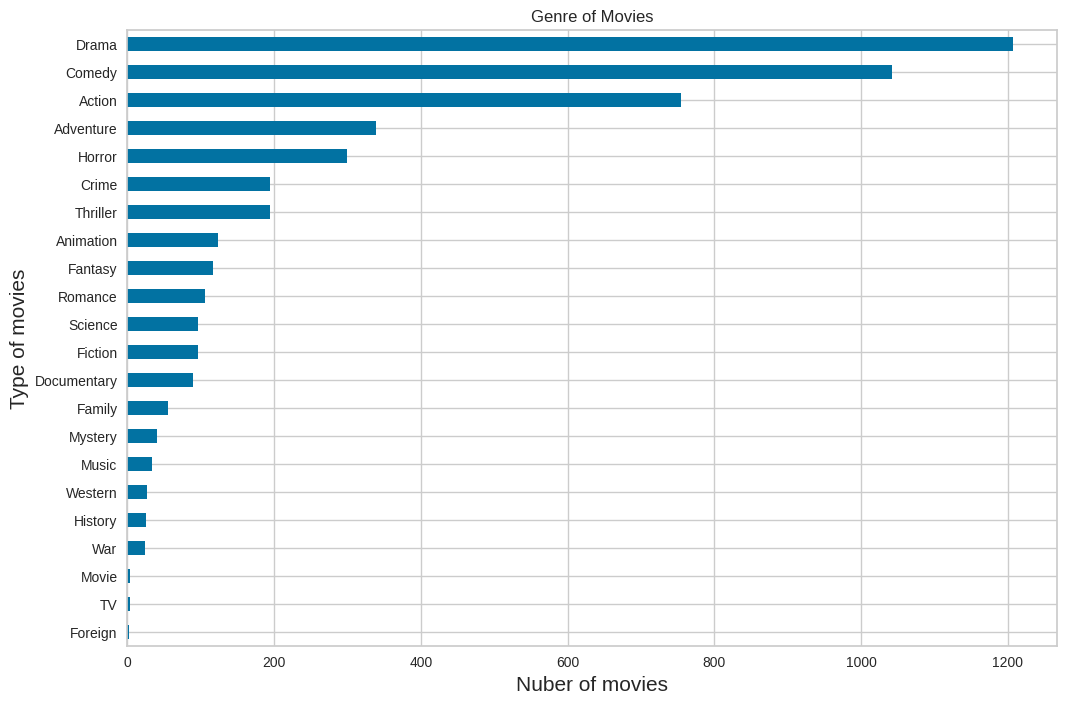

In [ ]:
fig=plt.figure(figsize=(12,8))
ax1 = plt.subplot(111)
rects = genresdfSum.sort_values(ascending=True).plot(kind='barh',label='genres')
plt.title('Genre of Movies')
plt.xlabel('Nuber of movies',fontsize=15)
plt.ylabel('Type of movies',fontsize=15)
plt.show()

Text(0.5, 1.0, 'Pie Chart Representation')

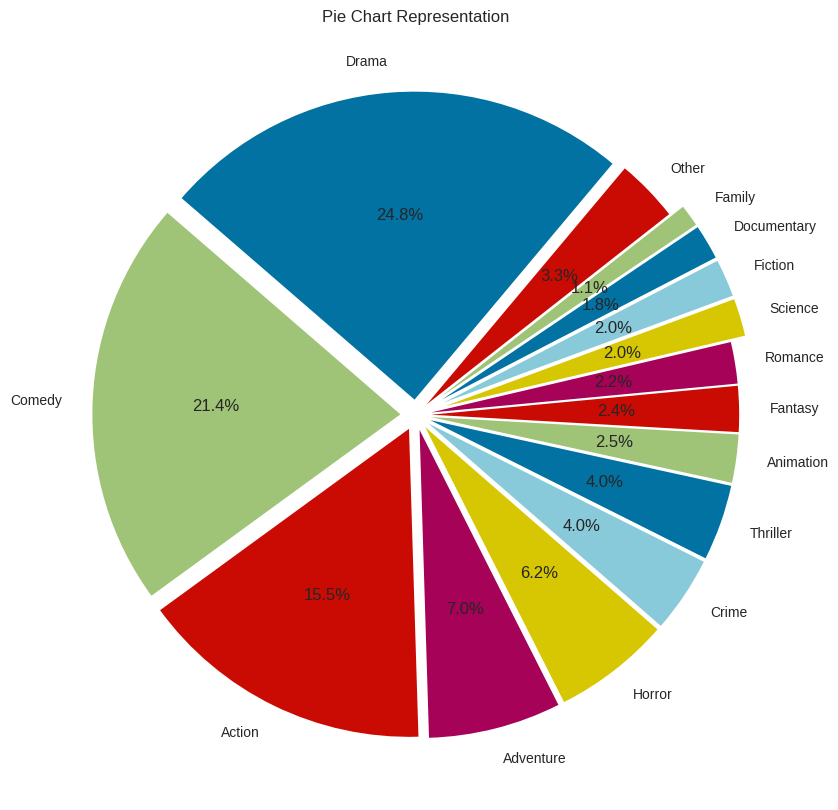

In [ ]:
genres_pie = genresdfSum / genresdfSum.sum()
others = 0.01
genres_pie_otr = genres_pie[genres_pie >= others]
genres_pie_otr['Other'] = genres_pie[genres_pie < others].sum()
explode = (genres_pie_otr <= 0.02) / 20 + 0.05
genres_pie_otr.plot(kind='pie',label='',startangle=50,shadow=False,figsize=(10,10),autopct='%1.1f%%',explode=explode)
plt.title('Pie Chart Representation')

## Year-wise comparision of different genres

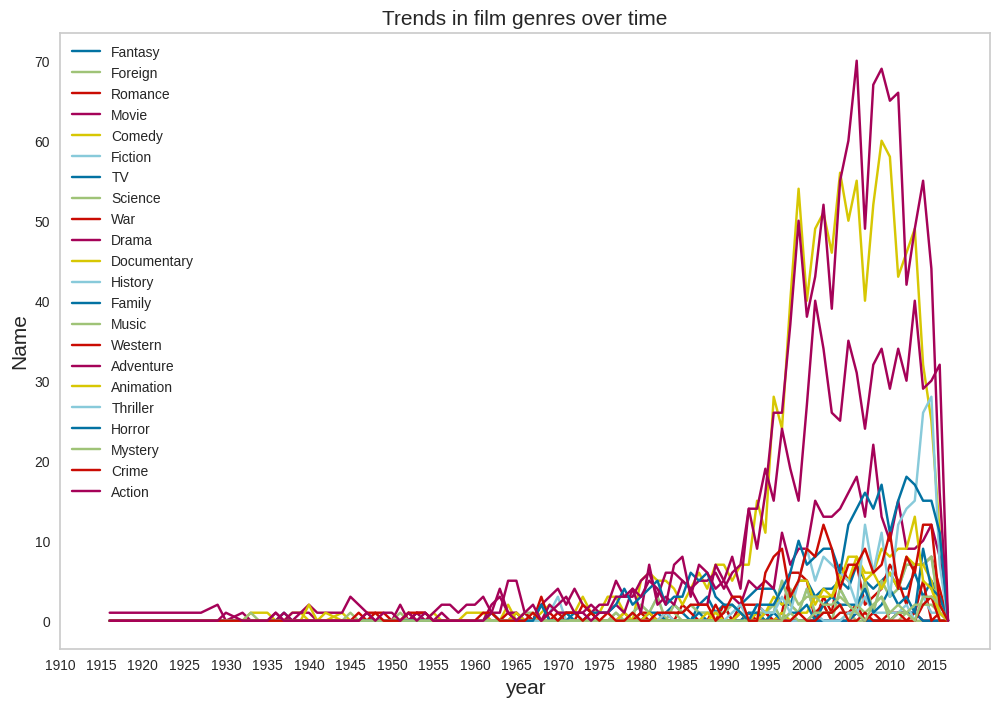

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(genresdf,label=genresdf.columns)
plt.xticks(range(1910,2018,5))
plt.legend(genresdf)
plt.title('Trends in film genres over time',fontsize=15)
plt.xlabel('year',fontsize=15)
plt.ylabel('Name',fontsize=15)
plt.grid(False)
plt.show()

In [ ]:
mean_genre_profit = pd.DataFrame(index=genres_list)

In [ ]:
newarray = []
for genre in genres_list:
    newarray.append(movies_df.groupby(genre,as_index=True)['profit'].mean())
newarray2 = []
for i in range(len(genres_list)):
    newarray2.append(newarray[i][1])
mean_genre_profit['mean_profit'] = newarray2

## Average profit by film genre

<Figure size 1200x800 with 0 Axes>

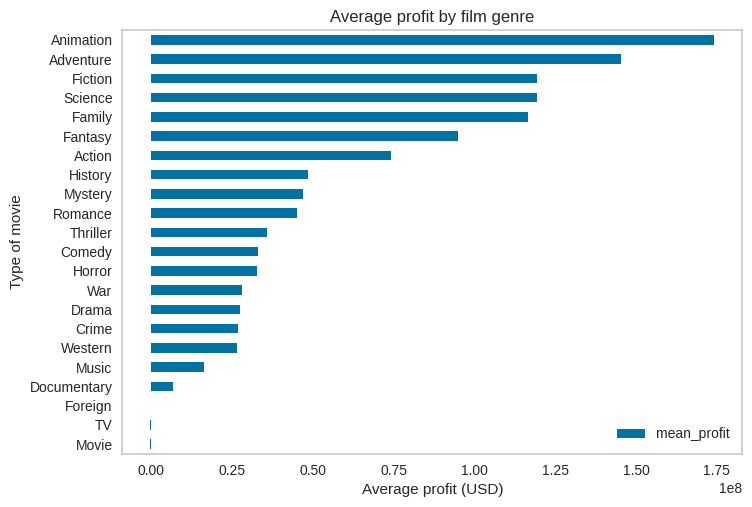

In [ ]:
plt.figure(figsize=(12,8))
mean_genre_profit.sort_values(by='mean_profit',ascending=True).plot(kind='barh')
plt.title('Average profit by film genre')
plt.xlabel('Average profit (USD)')
plt.ylabel('Type of movie')
plt.grid(False)
plt.show()

In [ ]:
movies_df['original_title'] = movies_df['original_title'].astype('str')
movies_df['overview'] = movies_df['overview'].astype('str')
movies_df['keywords'] = movies_df['keywords'].astype('str')

In [ ]:
title_corpus = ' '.join(movies_df['original_title'])
overview_corpus = ' '.join(movies_df['overview'])
keywords_corpus = ' '.join(movies_df['keywords'])

### Most words in original_title

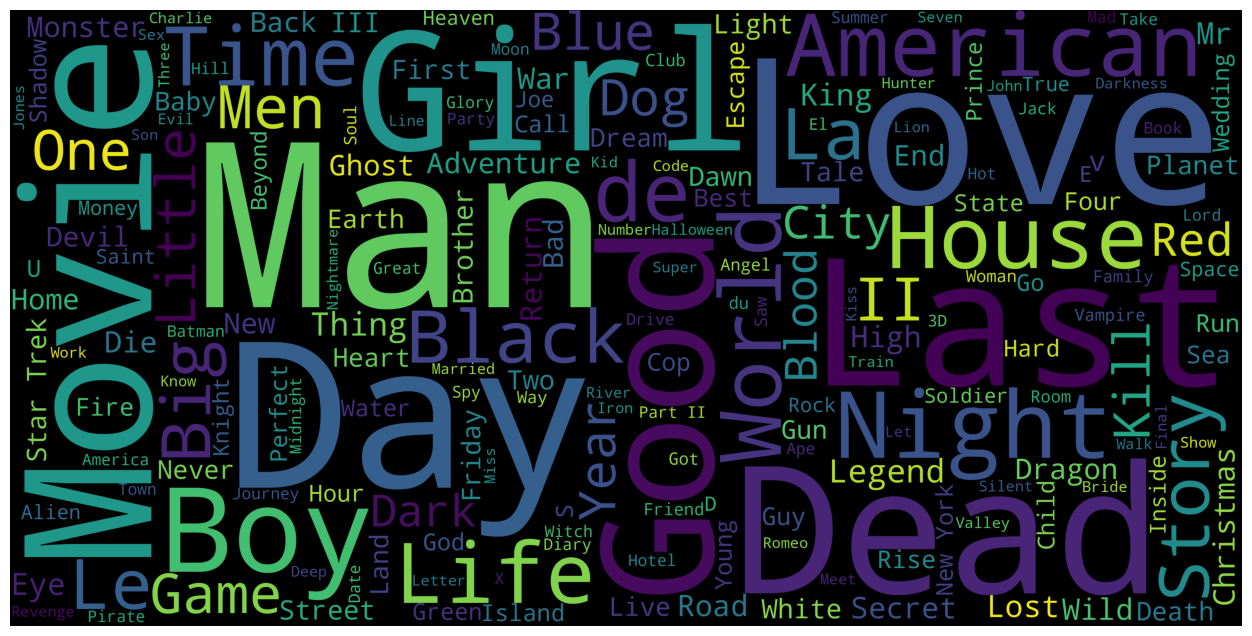

In [ ]:
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

### Most words in overview

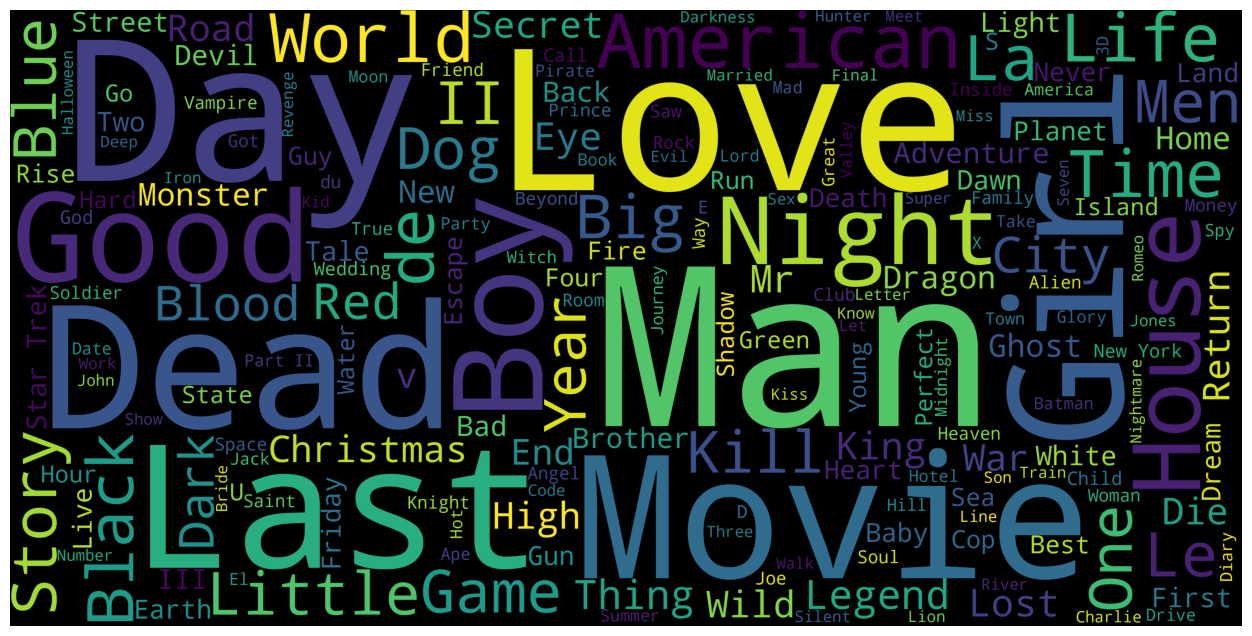

In [ ]:
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

### Most words in keywords

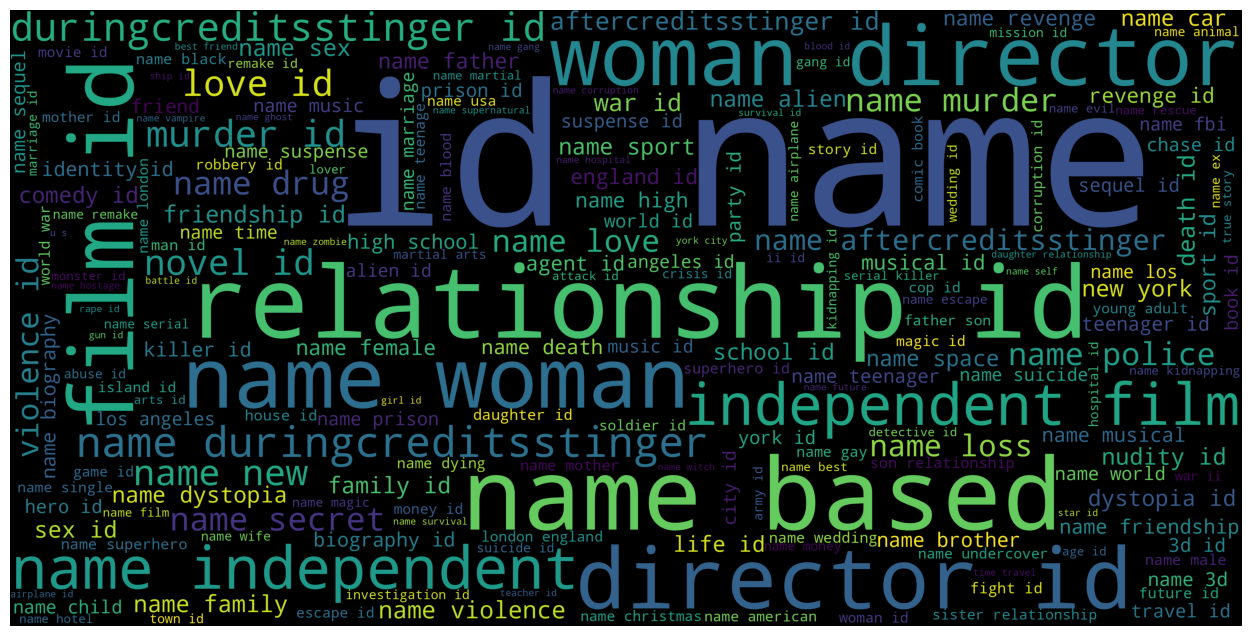

In [ ]:
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(keywords_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

# **Feature Engineering**

In [ ]:
"""
This function can be used to gain insights into the relationships and patterns within the data in a lower-dimensional space
because it will take high-dimensional data and labels and apply t-SNE for dimensionality reduction
"""
def plot_TSNE(data, labels):
    tsne = TSNEVisualizer()
    tsne.fit(data, labels)
    plt.xlabel("TSNE x")
    plt.ylabel("TSNE y")
    plt.title("TSNE Visualization")
    tsne.show()

##BOW

In [ ]:
"""
create bag of words from the partitions column
as the model will not take words , it can take numbers so we created bow vector representation


"""
coun_vect = CountVectorizer()
BOW_vectors = coun_vect.fit_transform(movies_df['overview'])
count_array = BOW_vectors.toarray()
df_bow = pd.DataFrame(count_array,columns = coun_vect.get_feature_names_out())

df_bow

,00,000,007,07am,10,100,1000,101,108,10th,...,zuckerberg,zula,zuzu,zyklon,æon,éloigne,émigré,été,única,über
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4800,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4801,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### plot the tsne distrbution for the bow dataframe

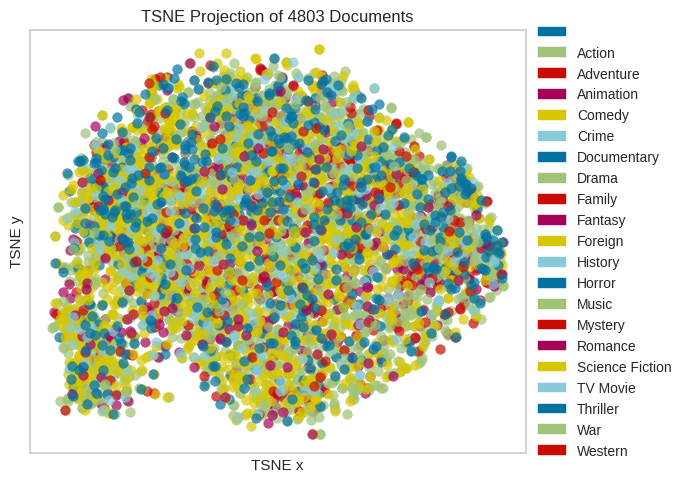

In [ ]:
plot_TSNE(df_bow,movies_df['genres'])

##TF_IDF

In [ ]:
tfidf_vectorizer=TfidfVectorizer()
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(movies_df['overview'])
count_array = tfidf_vectorizer_vectors.toarray()
df_tfidf = pd.DataFrame(count_array,columns=tfidf_vectorizer.get_feature_names_out())

df_tfidf

,00,000,007,07am,10,100,1000,101,108,10th,...,zuckerberg,zula,zuzu,zyklon,æon,éloigne,émigré,été,única,über
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###plot the tsne distrbution for the tf-idf dataframe

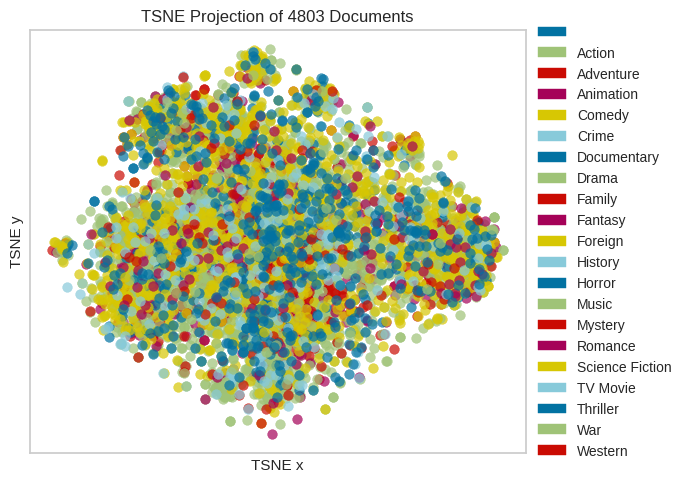

In [ ]:
plot_TSNE(df_tfidf,movies_df['genres'])

# **Training Data preparation**

In [ ]:
class_df = movies[['overview', 'genres']]

In [ ]:
# Preprocessing
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if isinstance(text, str):  # Check if the input is a valid string
        # Convert text to lowercase and remove punctuation using regex
        text = re.sub(r'[^a-zA-Z\s]', '', text.lower())

        # Tokenization
        tokens = word_tokenize(text)

        # Remove stop words
        stop_words = set(stopwords.words('english'))
        filtered_tokens = [token for token in tokens if token not in stop_words]

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

        return ' '.join(lemmatized_tokens)
    else:
        return ""


# Preprocess the genres column to extract the genre names
def extract_genre_names(genre_str):
    genre_list = ast.literal_eval(genre_str)
    genre_names = [genre_dict['name'] for genre_dict in genre_list]
    return ', '.join(genre_names)

In [ ]:
# Apply preprocessing to 'overview' column
class_df['cleaned_overview'] = class_df['overview'].apply(preprocess_text)

In [ ]:
# Apply the extraction function to create a new 'genre_names' column
class_df['genre_names'] = class_df['genres'].apply(extract_genre_names)

# Drop the original 'genres' column (optional)
class_df.drop(columns=['genres'], inplace=True)
class_df.drop(columns='overview',axis=1,inplace=True)
class_df['tokenized_overview'] = class_df['cleaned_overview'].apply(word_tokenize)
class_df.drop(columns='cleaned_overview',axis=1,inplace=True)

In [ ]:
class_df

,genre_names,tokenized_overview
0,"Action, Adventure, Fantasy, Science Fiction","[nd, century, paraplegic, marine, dispatched, ..."
1,"Adventure, Fantasy, Action","[captain, barbossa, long, believed, dead, come..."
2,"Action, Adventure, Crime","[cryptic, message, bond, past, sends, trail, u..."
3,"Action, Crime, Drama, Thriller","[following, death, district, attorney, harvey,..."
4,"Action, Adventure, Science Fiction","[john, carter, warweary, former, military, cap..."
...,...,...
4798,"Action, Crime, Thriller","[el, mariachi, want, play, guitar, carry, fami..."
4799,"Comedy, Romance","[newlywed, couple, honeymoon, upended, arrival..."
4800,"Comedy, Drama, Romance, TV Movie","[signed, sealed, delivered, introduces, dedica..."
4801,,"[ambitious, new, york, attorney, sam, sent, sh..."


Encode features

In [ ]:
# Convert the list of tokenized words to string
class_df['tokenized_overview'] = class_df['tokenized_overview'].apply(lambda tokens: ' '.join(tokens))

# Create a Bag-of-Words vectorizer
bow_vectorizer = CountVectorizer()

# Fit and transform the text data to get the BoW matrix
bow_matrix = bow_vectorizer.fit_transform(class_df['tokenized_overview'].values.astype('U'))

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text data to get the TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(class_df['tokenized_overview'].values.astype('U'))


## **Clustring K-means**

In [ ]:
# Visualize the clustering using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(tfidf_matrix.toarray())

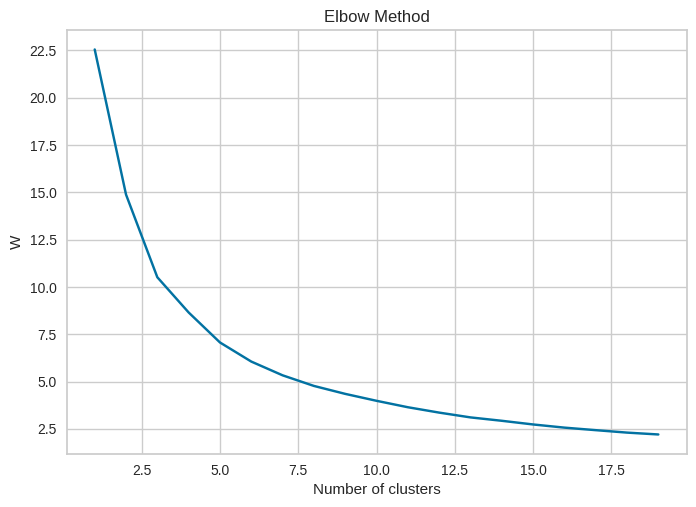

In [ ]:
w = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_pca)
    w.append(kmeans.inertia_)

plt.plot(range(1, 20), w[0:19])  # Adjusted the range for plotting
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('W')
plt.show()

In [ ]:
num_clusters = 3

# Perform clustering using KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
class_df['cluster'] = kmeans.fit_predict(X_pca)

In [ ]:
from sklearn.metrics import silhouette_score
#n_clustersfrom 2 to 7
for i in range(2,7):

  kmeans = KMeans(n_clusters=i, random_state=33,init="k-means++",n_init=10)
  kmeans.fit(X_pca)
  labels = kmeans.fit_predict(X_pca)
  sil_bow= silhouette_score(X_pca,class_df['cluster'])
  print(f'silhouette_score {i}=',sil_bow)

silhouette_score 2= 0.32360936962261
silhouette_score 3= 0.32360936962261
silhouette_score 4= 0.32360936962261
silhouette_score 5= 0.32360936962261
silhouette_score 6= 0.32360936962261


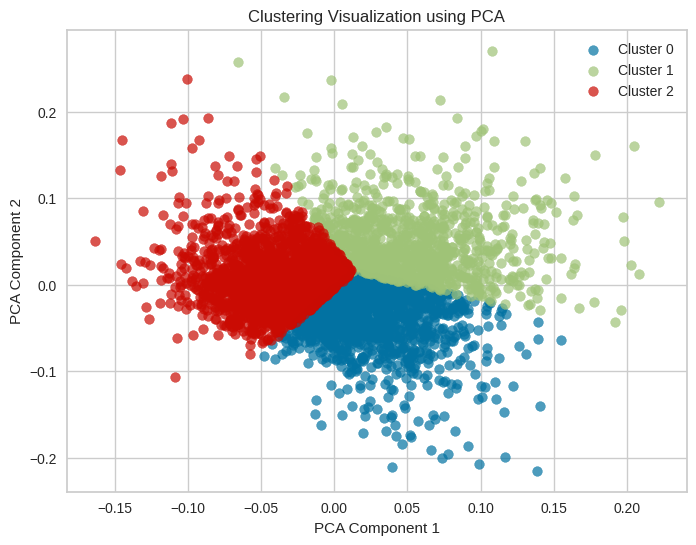

In [ ]:
# Create a scatter plot to visualize the clustering results
plt.figure(figsize=(8, 6))
for cluster_num in range(num_clusters):
    cluster_indices = class_df['cluster'] == cluster_num
    plt.scatter(X_pca[cluster_indices, 0], X_pca[cluster_indices, 1], label=f'Cluster {cluster_num}', alpha=0.7)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clustering Visualization using PCA')
plt.legend()
plt.show()

In [ ]:
# Function to find the most common genre in each cluster
def most_common_genre(genres):
    genre_count = {}
    for genre_list in genres:
        for genre in genre_list.split(', '):
            genre_count[genre] = genre_count.get(genre, 0) + 1
    return max(genre_count, key=genre_count.get)

# Group the data by cluster and find the most common genre for each cluster
cluster_genres = class_df.groupby('cluster')['genre_names'].apply(most_common_genre).reset_index()
cluster_genres.rename(columns={'genre_names': 'most_common_genre'}, inplace=True)

In [ ]:
# Merge the cluster_genres DataFrame with the original class_df
class_df = class_df.merge(cluster_genres, on='cluster', how='left')
class_df.drop(columns=['cluster', 'genre_names'], inplace=True)
class_df.rename(columns={'most_common_genre': 'genre_names'}, inplace=True)

In [ ]:
unique_genres = class_df.genre_names.unique()
print(unique_genres)

['Action' 'Drama' 'Comedy']


In [ ]:
class_df

,tokenized_overview,genre_names
0,nd century paraplegic marine dispatched moon p...,Action
1,captain barbossa long believed dead come back ...,Drama
2,cryptic message bond past sends trail uncover ...,Action
3,following death district attorney harvey dent ...,Action
4,john carter warweary former military captain w...,Action
...,...,...
4798,el mariachi want play guitar carry family trad...,Drama
4799,newlywed couple honeymoon upended arrival resp...,Drama
4800,signed sealed delivered introduces dedicated q...,Drama
4801,ambitious new york attorney sam sent shanghai ...,Drama


## **Classification models**

In [ ]:
# Convert the genres into one-hot encoded labels for the updated dataset
one_hot_genres = class_df['genre_names'].str.get_dummies(', ')

X_tfidf = tfidf_matrix
X_bow = bow_matrix
y = one_hot_genres
y_labels = y.idxmax(axis=1)

Split the data into training and testing sets

Split for bow representation

In [ ]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, y_labels, test_size=0.2, random_state=42)

Split for tfidf representation

In [ ]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y_labels, test_size=0.2, random_state=42)

In [ ]:
# Models to classification
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

In [ ]:
# Lists to store accuracy results
accuracies_bow = []
accuracies_tfidf = []


Results using Bag-of-Words:

Classification Report - Logistic Regression (BoW):
              precision    recall  f1-score   support

      Action       0.87      0.85      0.86       331
      Comedy       0.76      0.68      0.72       100
       Drama       0.85      0.88      0.87       530

    accuracy                           0.85       961
   macro avg       0.83      0.80      0.81       961
weighted avg       0.85      0.85      0.85       961



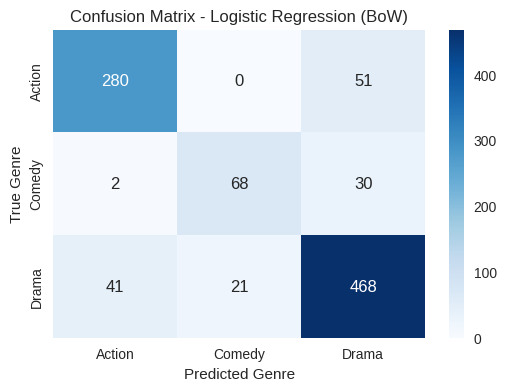


Classification Report - Random Forest (BoW):
              precision    recall  f1-score   support

      Action       0.89      0.74      0.81       331
      Comedy       1.00      0.26      0.41       100
       Drama       0.76      0.95      0.84       530

    accuracy                           0.81       961
   macro avg       0.89      0.65      0.69       961
weighted avg       0.83      0.81      0.79       961



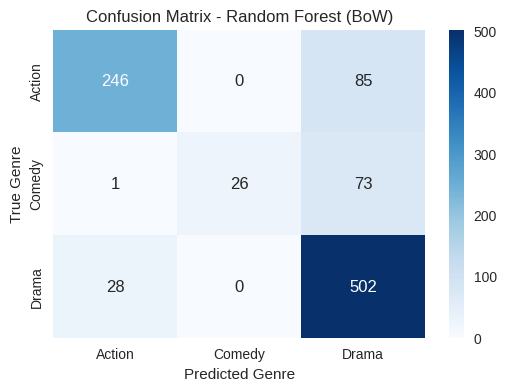


Classification Report - SVM (BoW):
              precision    recall  f1-score   support

      Action       0.86      0.82      0.84       331
      Comedy       0.79      0.77      0.78       100
       Drama       0.86      0.88      0.87       530

    accuracy                           0.85       961
   macro avg       0.83      0.82      0.83       961
weighted avg       0.85      0.85      0.85       961



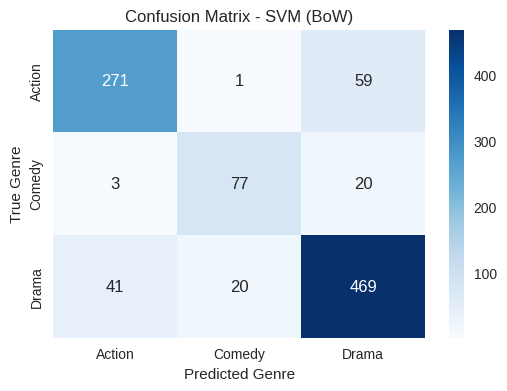


Classification Report - Decision Tree (BoW):
              precision    recall  f1-score   support

      Action       0.75      0.72      0.73       331
      Comedy       0.49      0.58      0.53       100
       Drama       0.79      0.79      0.79       530

    accuracy                           0.74       961
   macro avg       0.68      0.69      0.68       961
weighted avg       0.75      0.74      0.74       961



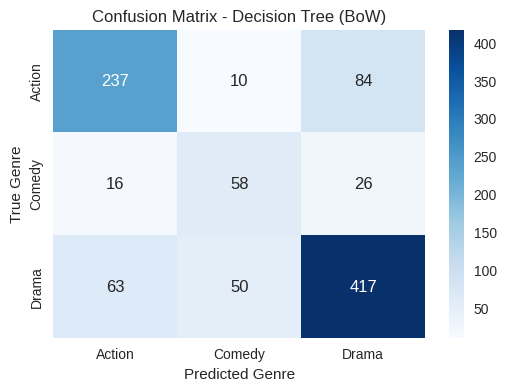

In [ ]:
# Train and evaluate models using BoW representation
print("Results using Bag-of-Words:")
for model_name, model in models.items():
    model.fit(X_train_bow, y_train_bow)
    predictions = model.predict(X_test_bow)
    accuracy = accuracy_score(y_test_bow, predictions)
    accuracies_bow.append(accuracy)

    # Print classification report
    print(f"\nClassification Report - {model_name} (BoW):")
    print(classification_report(y_test_bow, predictions))

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test_bow, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=one_hot_genres.columns, yticklabels=one_hot_genres.columns)
    plt.title(f'Confusion Matrix - {model_name} (BoW)')
    plt.xlabel('Predicted Genre')
    plt.ylabel('True Genre')
    plt.show()


Results using TF-IDF:

Classification Report - Logistic Regression (TF-IDF):
              precision    recall  f1-score   support

      Action       0.88      0.76      0.81       331
      Comedy       1.00      0.34      0.51       100
       Drama       0.78      0.95      0.86       530

    accuracy                           0.82       961
   macro avg       0.89      0.68      0.73       961
weighted avg       0.84      0.82      0.80       961



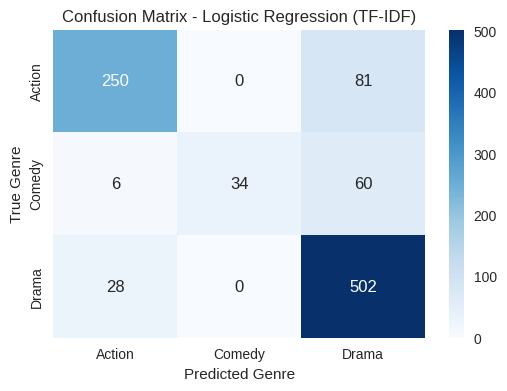


Classification Report - Random Forest (TF-IDF):
              precision    recall  f1-score   support

      Action       0.90      0.81      0.86       331
      Comedy       1.00      0.19      0.32       100
       Drama       0.78      0.95      0.86       530

    accuracy                           0.83       961
   macro avg       0.90      0.65      0.68       961
weighted avg       0.85      0.83      0.80       961



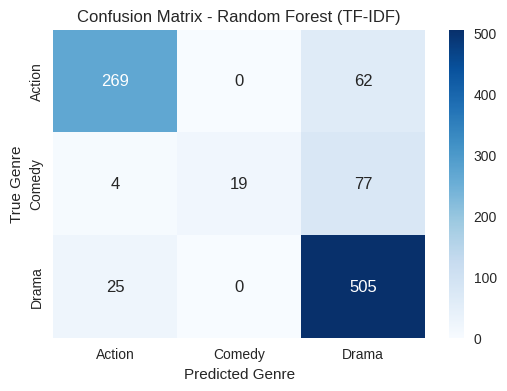


Classification Report - SVM (TF-IDF):
              precision    recall  f1-score   support

      Action       0.84      0.80      0.82       331
      Comedy       0.95      0.58      0.72       100
       Drama       0.82      0.91      0.86       530

    accuracy                           0.84       961
   macro avg       0.87      0.76      0.80       961
weighted avg       0.84      0.84      0.83       961



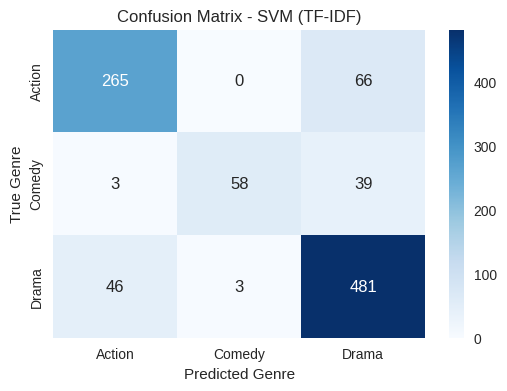


Classification Report - Decision Tree (TF-IDF):
              precision    recall  f1-score   support

      Action       0.71      0.69      0.70       331
      Comedy       0.59      0.55      0.57       100
       Drama       0.77      0.79      0.78       530

    accuracy                           0.73       961
   macro avg       0.69      0.68      0.68       961
weighted avg       0.73      0.73      0.73       961



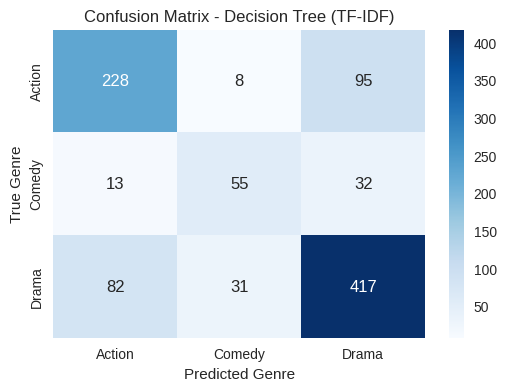

In [ ]:
# Train and evaluate models using TF-IDF representation
print("\nResults using TF-IDF:")
for model_name, model in models.items():
    model.fit(X_train_tfidf, y_train_tfidf)
    predictions = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test_tfidf, predictions)
    accuracies_tfidf.append(accuracy)

    # Print classification report
    print(f"\nClassification Report - {model_name} (TF-IDF):")
    print(classification_report(y_test_tfidf, predictions))

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test_tfidf, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=one_hot_genres.columns, yticklabels=one_hot_genres.columns)
    plt.title(f'Confusion Matrix - {model_name} (TF-IDF)')
    plt.xlabel('Predicted Genre')
    plt.ylabel('True Genre')
    plt.show()

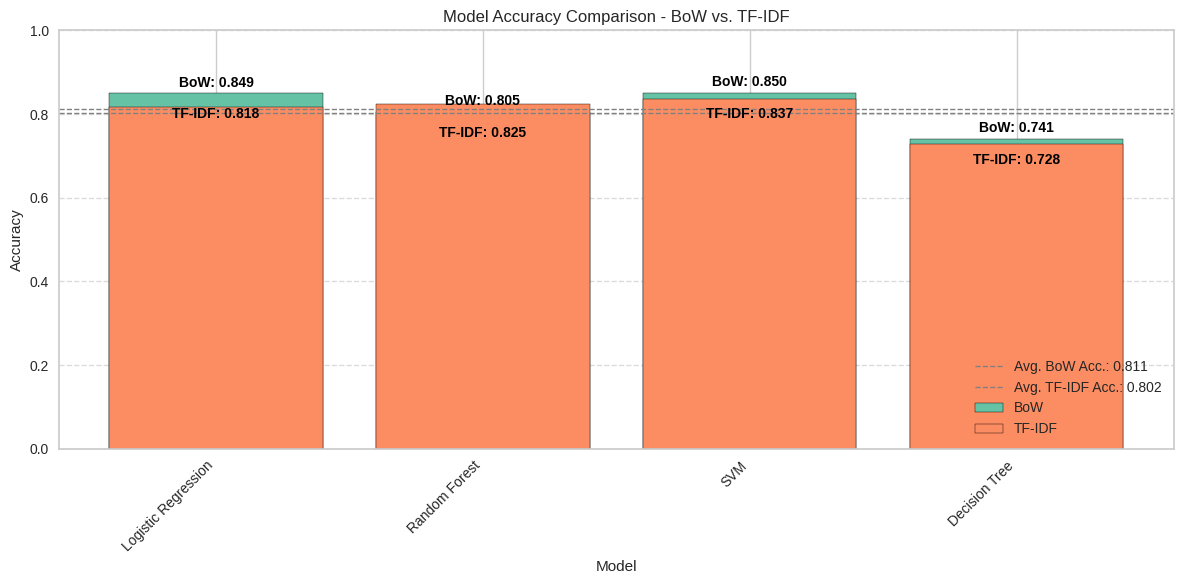

In [ ]:
# Compare model accuracies using BoW and TF-IDF
model_names = list(models.keys())

# Define colors using a custom color palette
colors = sns.color_palette('Set2', n_colors=2)

plt.figure(figsize=(12, 6))
bars1 = plt.bar(model_names, accuracies_bow, color=colors[0], label='BoW', edgecolor='black')
bars2 = plt.bar(model_names, accuracies_tfidf, color=colors[1], label='TF-IDF', edgecolor='black')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison - BoW vs. TF-IDF')
plt.ylim([0.0, 1.0])
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add custom legend with color labels
plt.legend(handles=[bars1, bars2], labels=['BoW', 'TF-IDF'], loc='upper left')

# Calculate average accuracy for each representation
avg_accuracy_bow = sum(accuracies_bow) / len(accuracies_bow)
avg_accuracy_tfidf = sum(accuracies_tfidf) / len(accuracies_tfidf)

# Annotate each bar with the accuracy value on top of the bar and its representation label
for bar, acc1, acc2 in zip(bars1 + bars2, accuracies_bow, accuracies_tfidf):
    height = bar.get_height()
    plt.annotate(f'BoW: {acc1*100:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5), textcoords='offset points', ha='center', fontsize=10, color='black',
                 fontweight='bold')

    plt.annotate(f'TF-IDF: {acc2*100:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, -18), textcoords='offset points', ha='center', fontsize=10, color='black',
                 fontweight='bold')

# Add horizontal lines to indicate the average accuracy for each representation
plt.axhline(y=avg_accuracy_bow, color='grey', linestyle='dashed', linewidth=1, label=f'Avg. BoW Acc.: {avg_accuracy_bow*100:.1f}%')
plt.axhline(y=avg_accuracy_tfidf, color='grey', linestyle='dashed', linewidth=1, label=f'Avg. TF-IDF Acc.: {avg_accuracy_tfidf*100:.1f}%')

plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
best_model_bow_idx = np.argmax(accuracies_bow)
best_model_tfidf_idx = np.argmax(accuracies_tfidf)

best_model_bow = model_names[best_model_bow_idx]
best_model_tfidf = model_names[best_model_tfidf_idx]
best_accuracy_bow = accuracies_bow[best_model_bow_idx]
best_accuracy_tfidf = accuracies_tfidf[best_model_tfidf_idx]

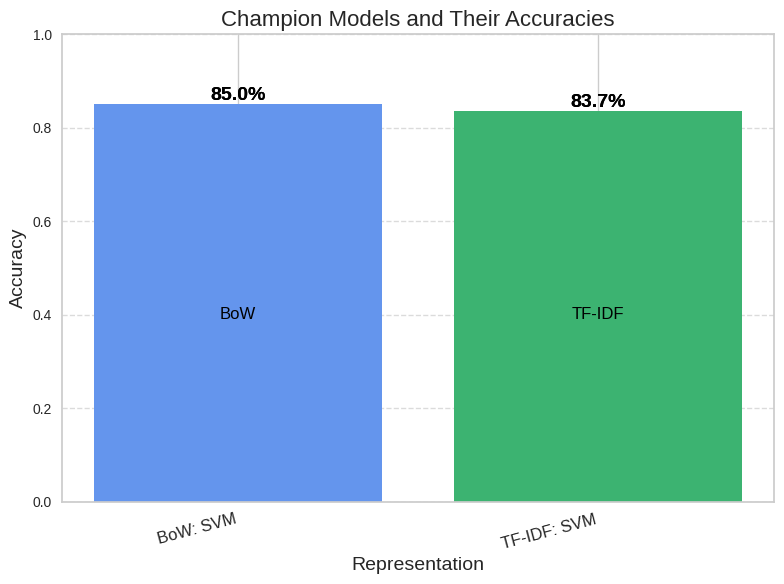

In [ ]:
models = [f"BoW: {best_model_bow}", f"TF-IDF: {best_model_tfidf}"]
accuracies = [best_accuracy_bow, best_accuracy_tfidf]

# Create a bar plot to visualize the champion models and their accuracies
plt.figure(figsize=(8, 6))
colors = ['cornflowerblue', 'mediumseagreen']
bars = plt.bar(models, accuracies, color=colors)
plt.xlabel("Representation", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Champion Models and Their Accuracies", fontsize=16)
plt.ylim(0, 1)  # Set the y-axis limit from 0 to 1 (accuracy range)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add labels to the bars with accuracy values as percentages
for bar, accuracy in zip(bars, accuracies):
    height = bar.get_height()
    plt.annotate(f"{accuracy*100:.1f}%", xy=(bar.get_x() + bar.get_width() / 2, height),
                 ha='center', va='bottom', fontsize=14, fontweight='bold', color='black')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=15, ha='right', fontsize=12)

# Add labels to BoW and TF-IDF bars
plt.text(0, best_accuracy_bow, f"{best_accuracy_bow*100:.1f}%", ha='center', va='bottom', fontsize=14, fontweight='bold', color='black')
plt.text(1, best_accuracy_tfidf, f"{best_accuracy_tfidf*100:.1f}%", ha='center', va='bottom', fontsize=14, fontweight='bold', color='black')

# Add explicit labels for BoW and TF-IDF
plt.text(0, .4, 'BoW', ha='center', va='center', fontsize=12, color='black')
plt.text(1, .4, 'TF-IDF', ha='center', va='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()

In [ ]:
print(f"\nThe champion model using BoW representation is: {best_model_bow} with an accuracy of {best_accuracy_bow:.4f}")
print(f"\nThe champion model TF-IDF representation is: {best_model_tfidf} with an accuracy of {best_accuracy_tfidf:.4f}")


The champion model using BoW representation is: SVM with an accuracy of 0.8502

The champion model TF-IDF representation is: SVM with an accuracy of 0.8366
